In [0]:
import tensorflow as tf
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time
import numpy as np

In [0]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)
path_to_file = os.path.dirname(path_to_zip)+'/spa-eng/spa.txt'

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w) # creating space between word and following punctuation
    w = re.sub(r'[" "]+', " ", w)        # creating space between word and following punctuation

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    #adding <start> and <end> tokens
    w = '<start> ' + w + ' <end>'

    return w


In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puede tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> may i borrow this book ? <end>
<start> ¿ puede tomar prestado este libro ? <end>


In [0]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, input_lang_tokenizer = tokenize(inp_lang)
    target_tensor, target_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, input_lang_tokenizer, target_tensor, target_lang_tokenizer

In [0]:
num_examples = 30000

input_tensor, inp_lang, target_tensor, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(input_tensor_val), len(target_tensor_train), len(target_tensor_val))

24000 6000 24000 6000


In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print('Input Language; index to word map')
convert(inp_lang, input_tensor_train[0])
print()
print('Target Language; index to word map')
convert(targ_lang, target_tensor_train[0])

Input Language; index to word map
1 ----> <start>
59 ----> tomas
47 ----> estaba
178 ----> realmente
184 ----> cansado
3 ----> .
2 ----> <end>

Target Language; index to word map
1 ----> <start>
5 ----> tom
26 ----> was
130 ----> really
147 ----> tired
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_targ_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)

(64, 16) (64, 11)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder hidden state shape (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder hidden state shape (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
    
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print('Attention Result Shape (batch size, units) {}'.format(attention_result.shape))
print('Attention Weights Shape (batch size, sequence length, 1) {}'.format(attention_weights.shape))

Attention Result Shape (batch size, units) (64, 1024)
Attention Weights Shape (batch size, sequence length, 1) (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))

        x = self.fc(output)

        return x, state, attention_weights

In [29]:
decoder = Decoder(vocab_targ_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden, sample_output)

print('Decoder Output Shape: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))

Decoder Output Shape: (batch_size, vocab_size) (64, 4935)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss/int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [36]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch%100 == 0:
            print('Epoch {} Batch {} Loss {:4f}'.format(epoch+1, batch, batch_loss.numpy()))

    if (epoch+1)%2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:4f}'.format(epoch+1, total_loss/steps_per_epoch))

    end = time.time()

    print("Time taken for 1 epoch: {} sec\n".format(end-start))

Epoch 1 Batch 0 Loss 4.554479
Epoch 1 Batch 100 Loss 2.183024
Epoch 1 Batch 200 Loss 1.929493
Epoch 1 Batch 300 Loss 1.866020
Epoch 1 Loss 2.032815
Time taken for 1 epoch: 38.2776825428009 sec

Epoch 2 Batch 0 Loss 1.646971
Epoch 2 Batch 100 Loss 1.539878
Epoch 2 Batch 200 Loss 1.424281
Epoch 2 Batch 300 Loss 1.316002
Epoch 2 Loss 1.382018
Time taken for 1 epoch: 27.171741008758545 sec

Epoch 3 Batch 0 Loss 1.055204
Epoch 3 Batch 100 Loss 0.979948
Epoch 3 Batch 200 Loss 0.863708
Epoch 3 Batch 300 Loss 0.884754
Epoch 3 Loss 0.956393
Time taken for 1 epoch: 26.660115957260132 sec

Epoch 4 Batch 0 Loss 0.681048
Epoch 4 Batch 100 Loss 0.724047
Epoch 4 Batch 200 Loss 0.537015
Epoch 4 Batch 300 Loss 0.619713
Epoch 4 Loss 0.635494
Time taken for 1 epoch: 26.947839498519897 sec

Epoch 5 Batch 0 Loss 0.412835
Epoch 5 Batch 100 Loss 0.328244
Epoch 5 Batch 200 Loss 0.466550
Epoch 5 Batch 300 Loss 0.429758
Epoch 5 Loss 0.426935
Time taken for 1 epoch: 26.499181032180786 sec

Epoch 6 Batch 0 Loss 0

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1,units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, rotation=90, fontdict=fontdict)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [40]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input <start> hace mucho frio aqui . <end>
Predicted translation: it is very cold here . <end> 


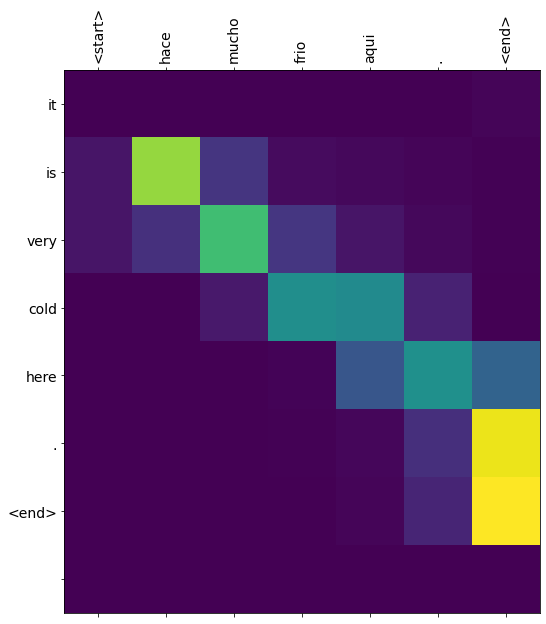

In [41]:
translate(u'hace mucho frio aqui.')

Input <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


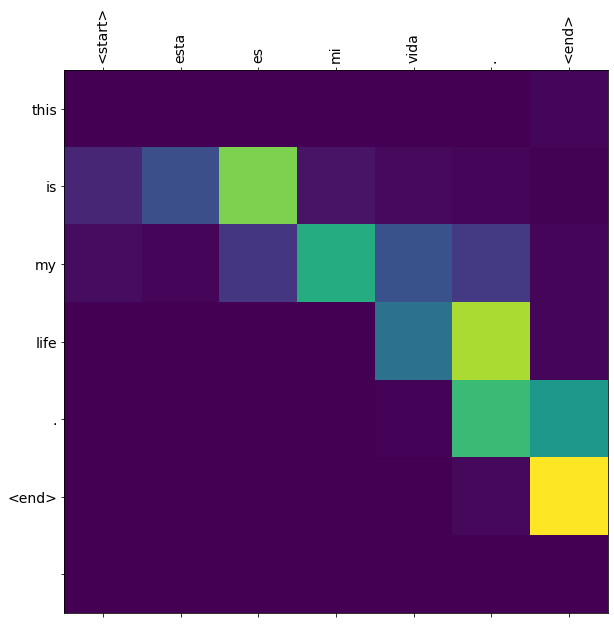

In [42]:
translate(u'esta es mi vida.')

Input <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


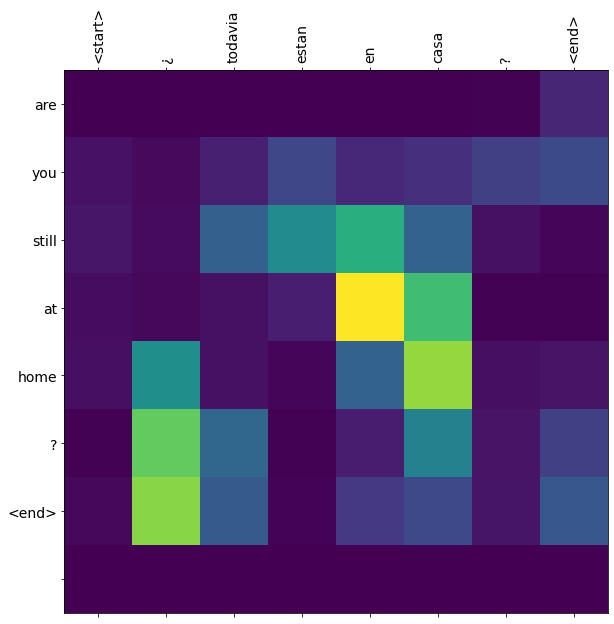

In [43]:
translate(u'¿todavia estan en casa?')

Input <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


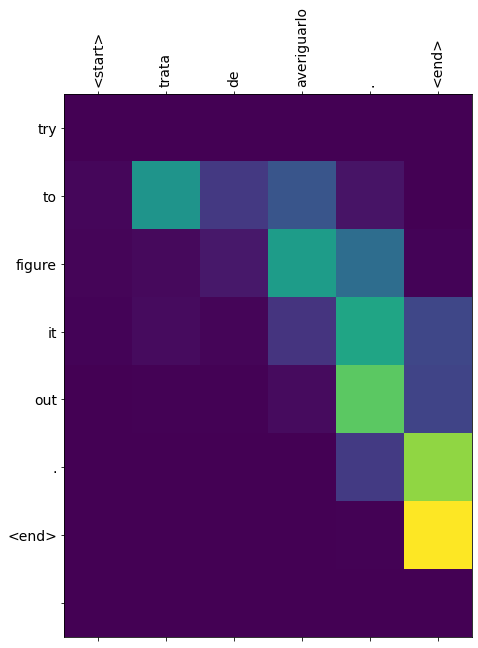

In [44]:
# wrong translation
translate(u'trata de averiguarlo.')